<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/Cosinor_phase_ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

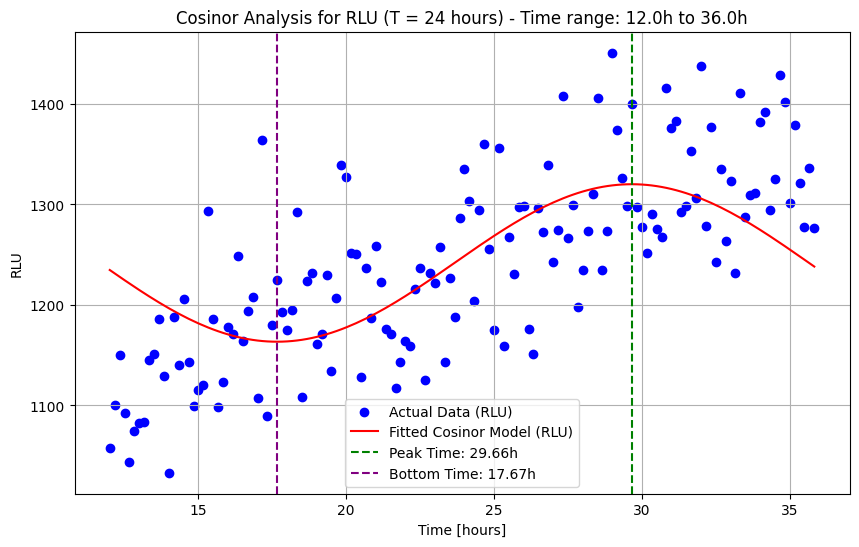

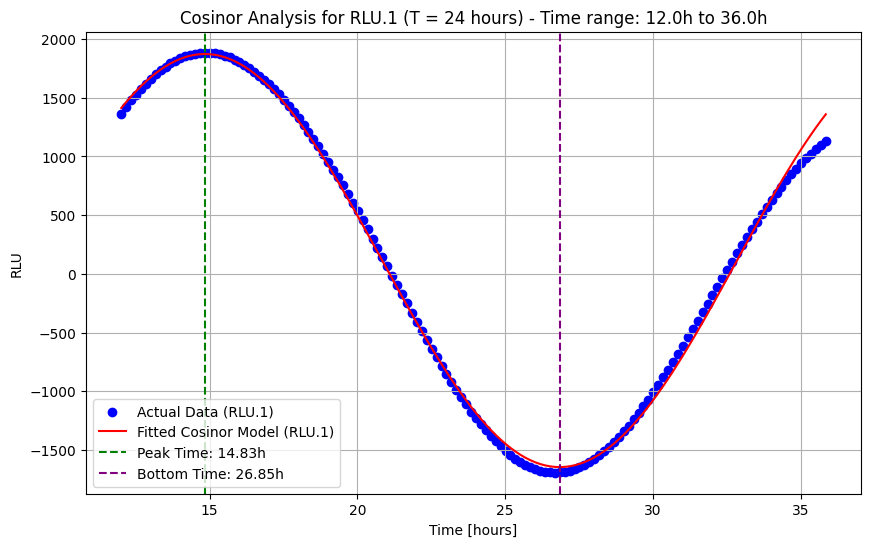

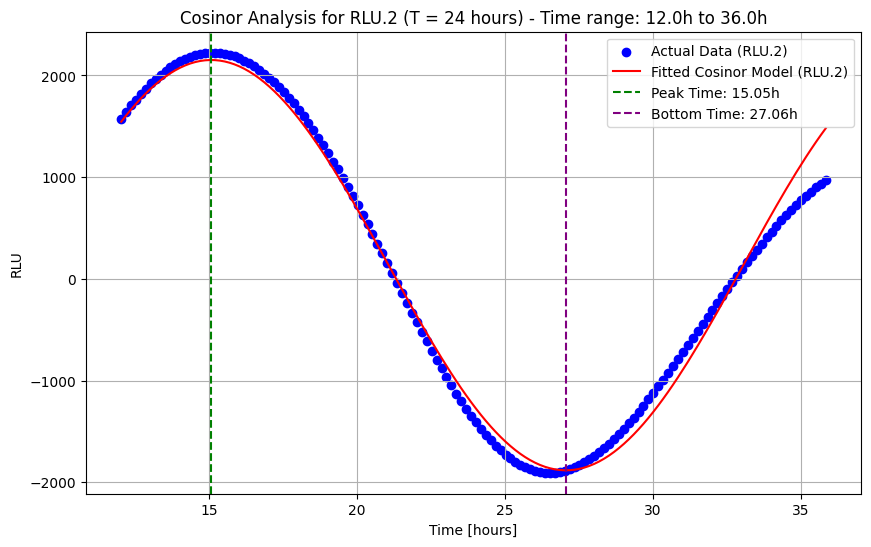

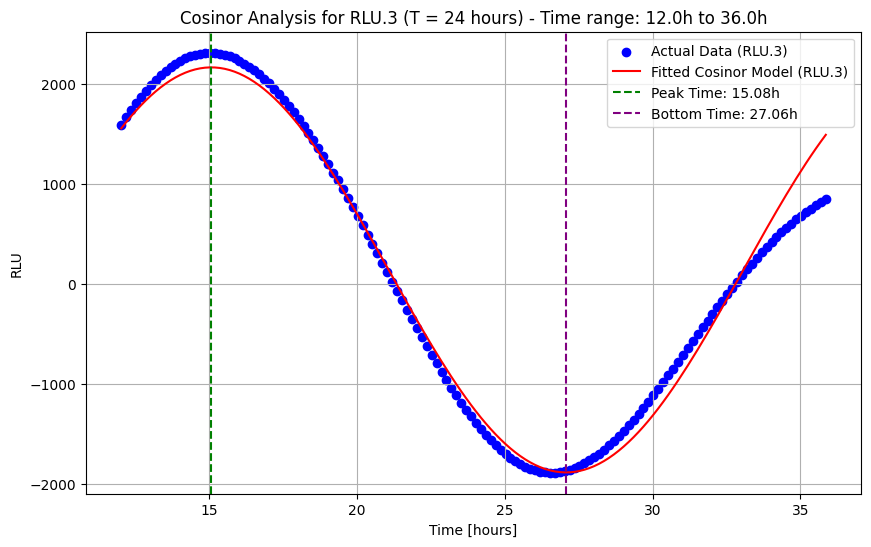

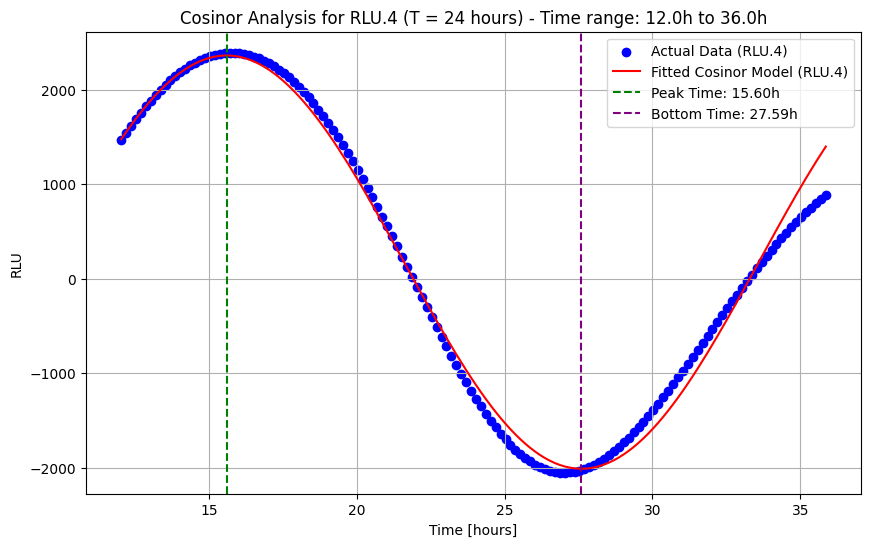

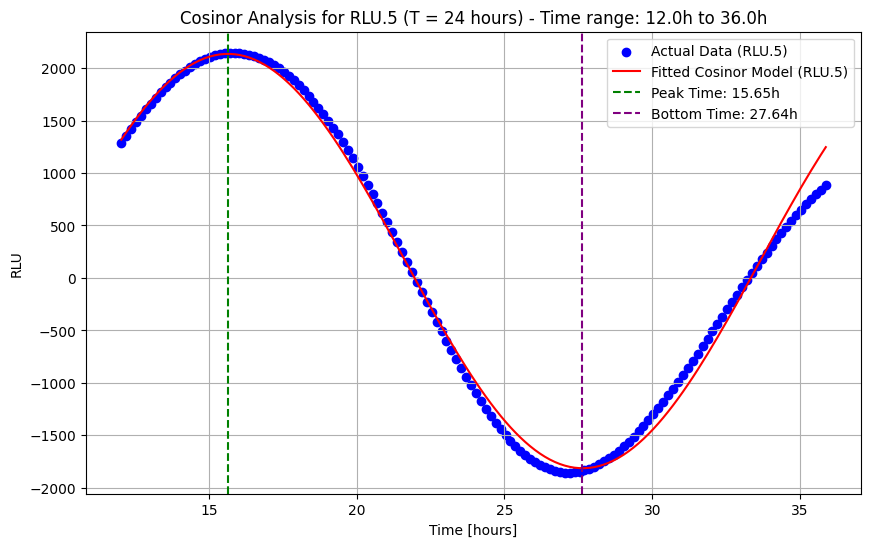

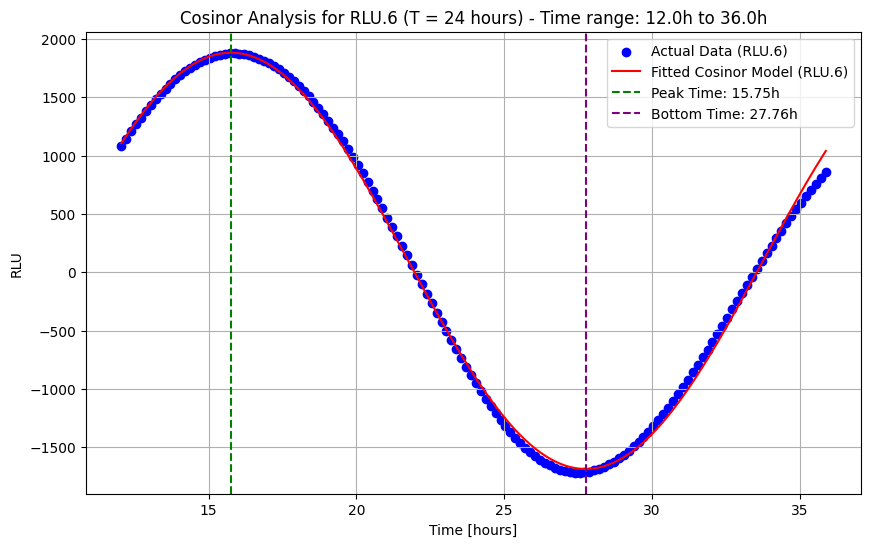

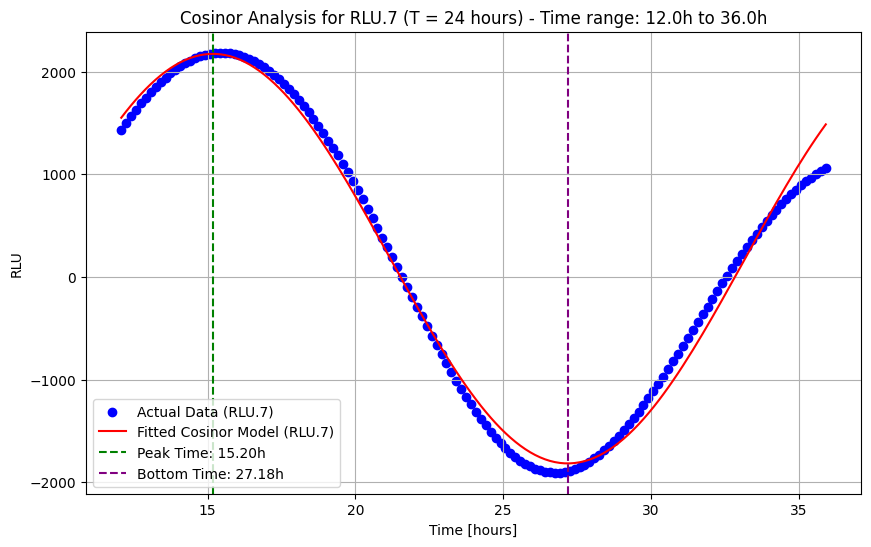

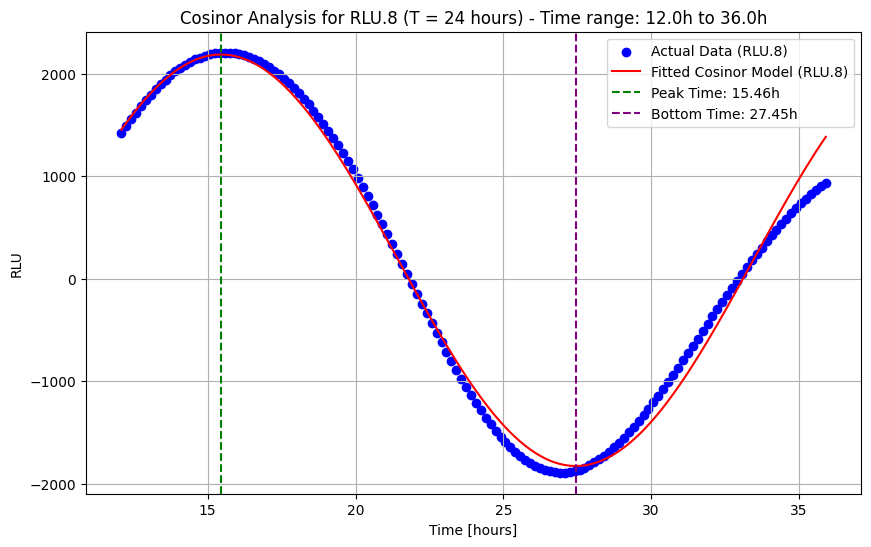

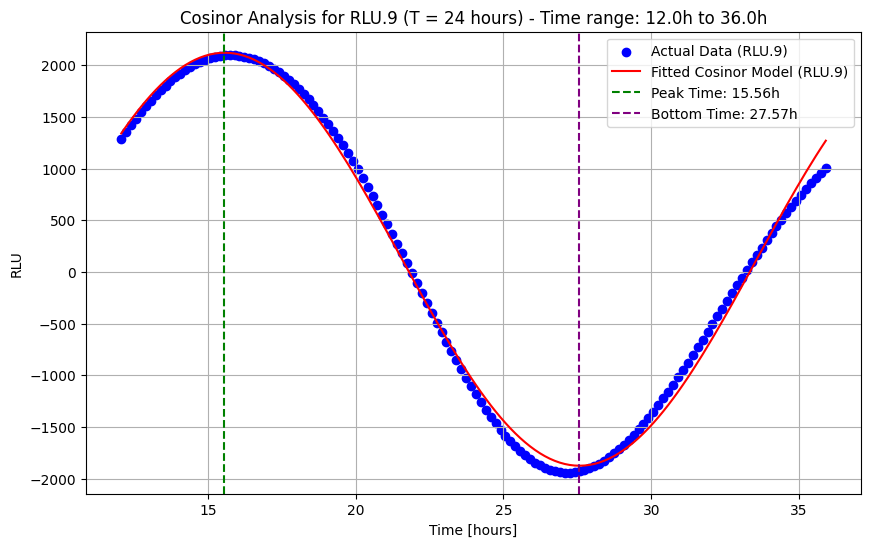

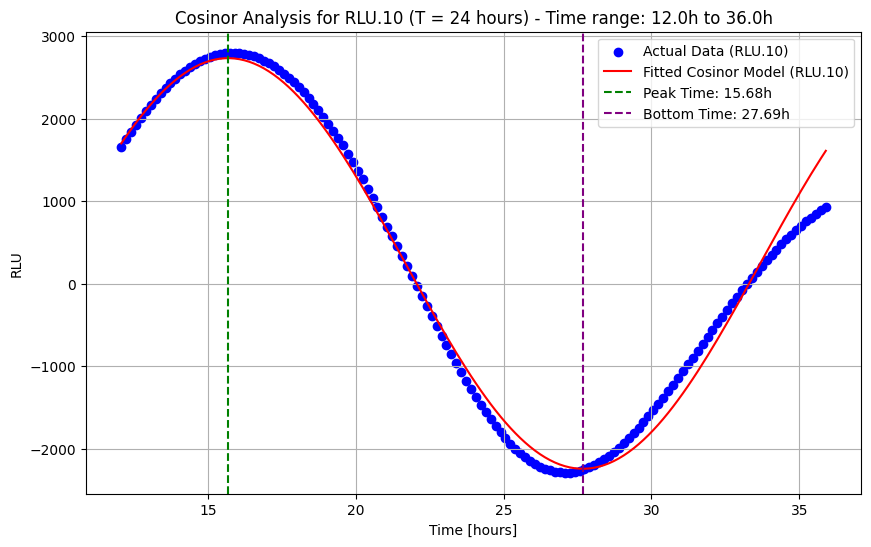

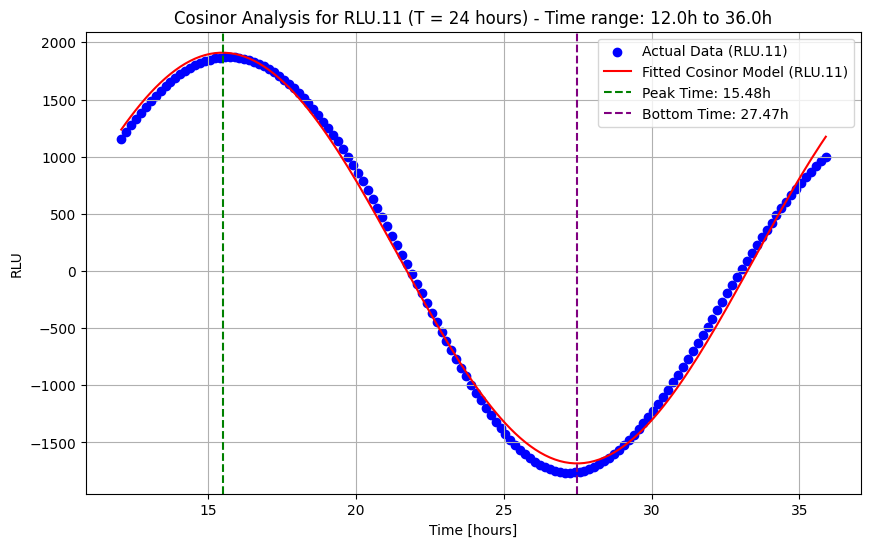

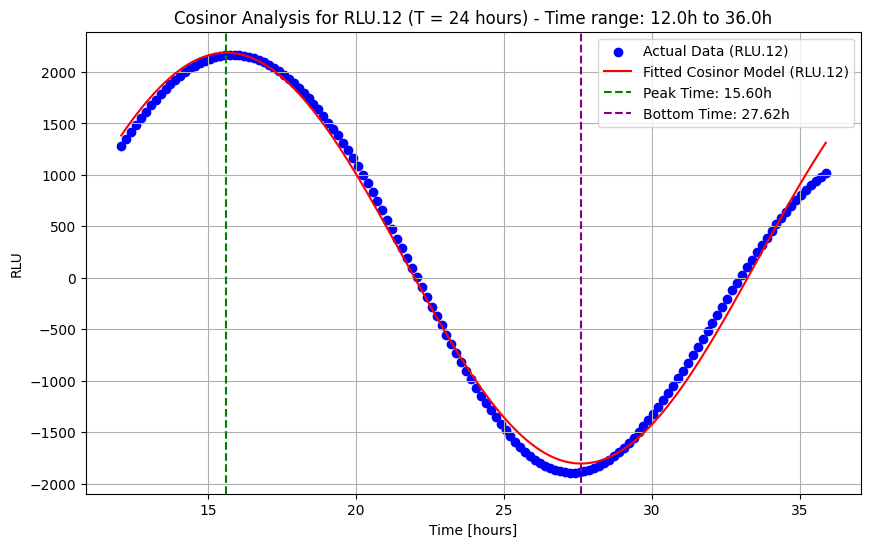

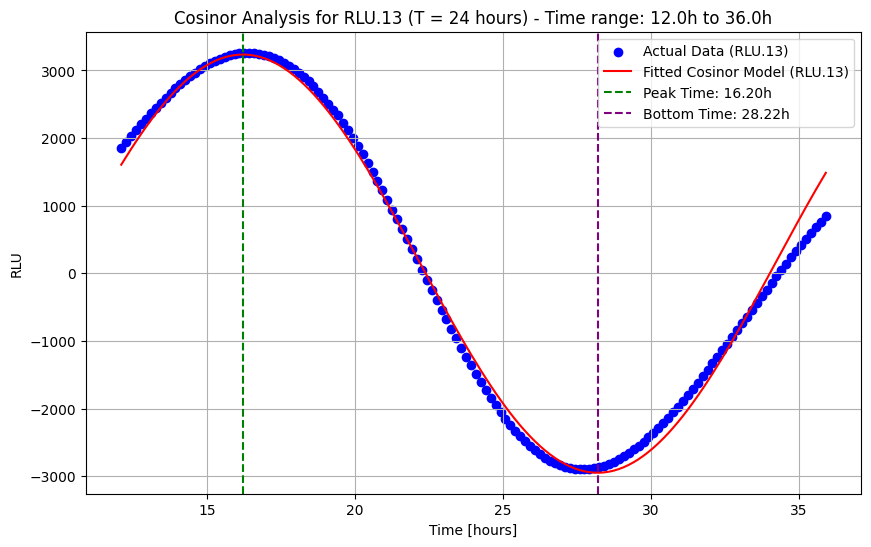

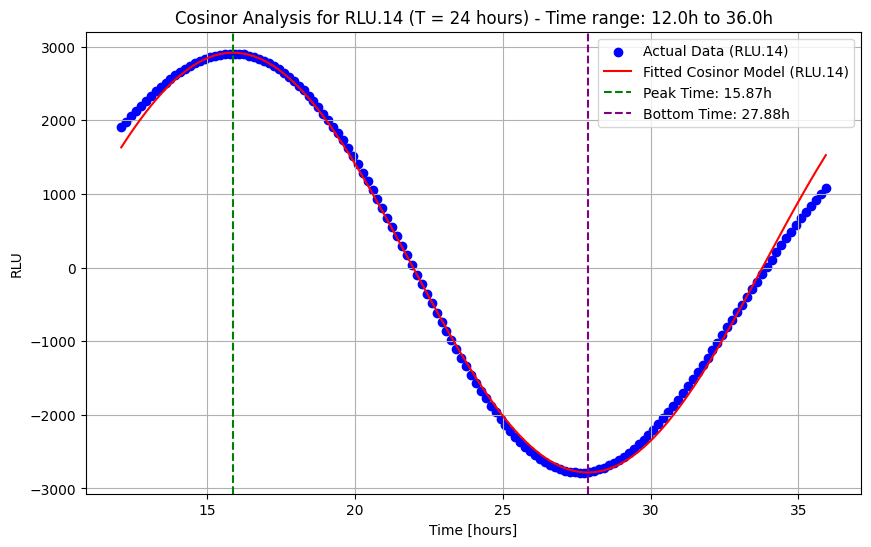

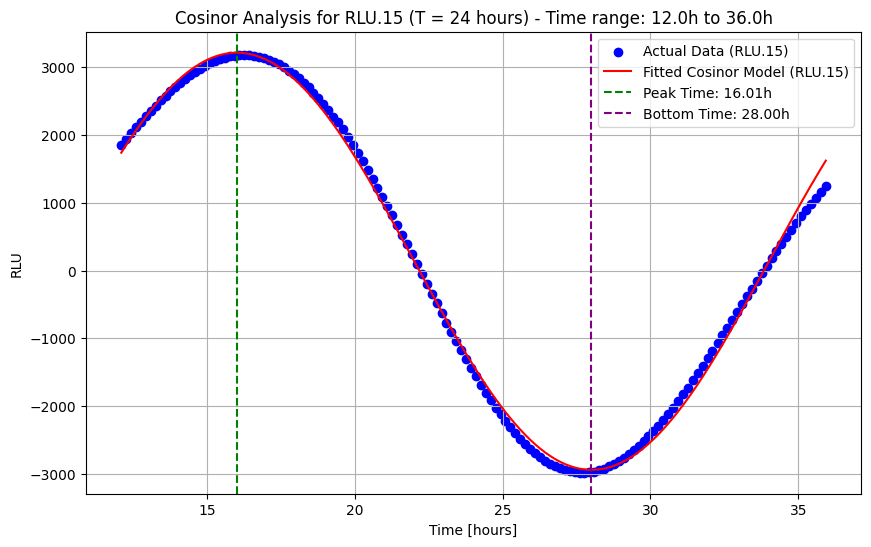

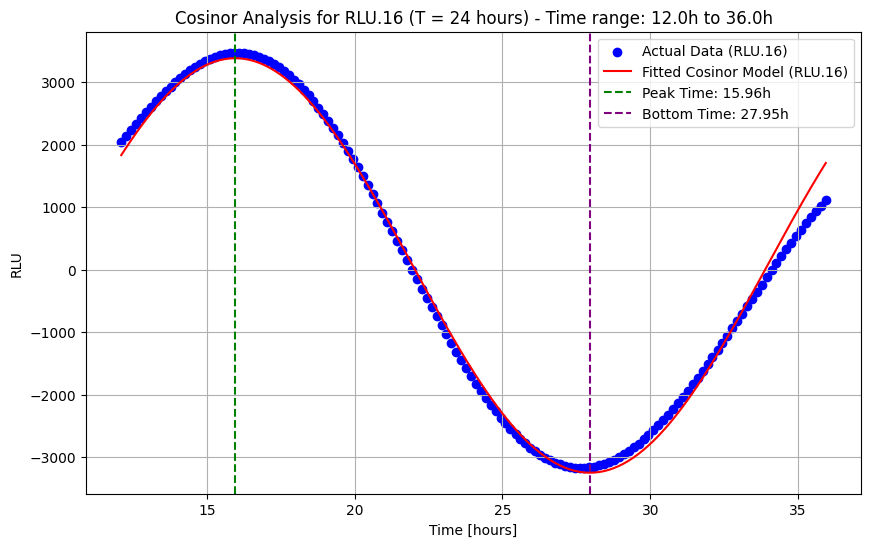

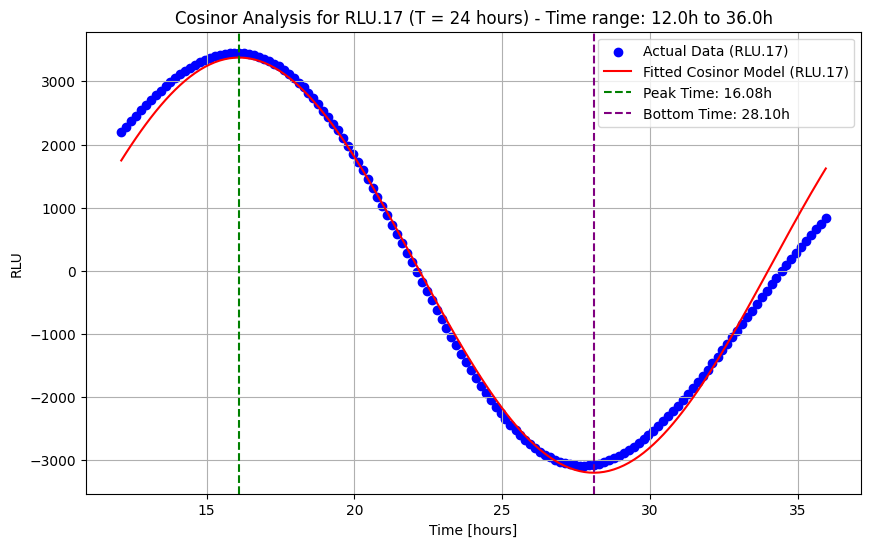

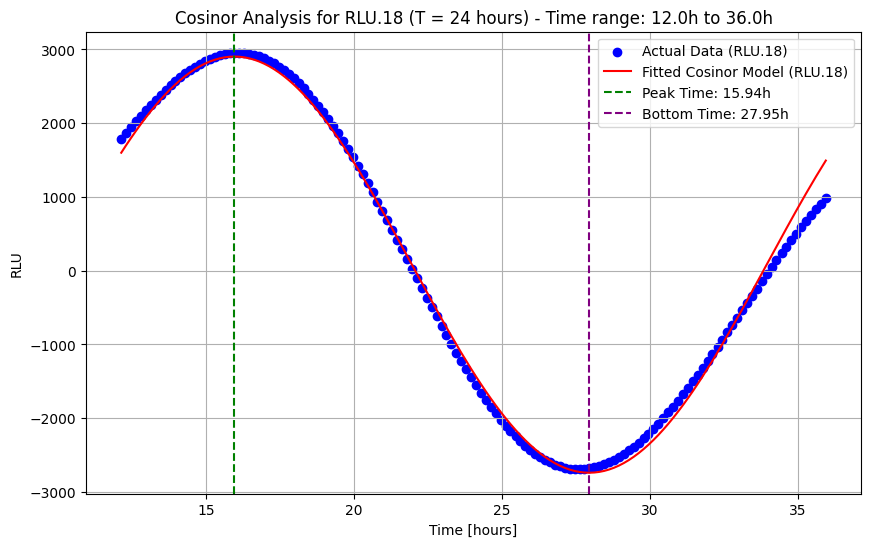

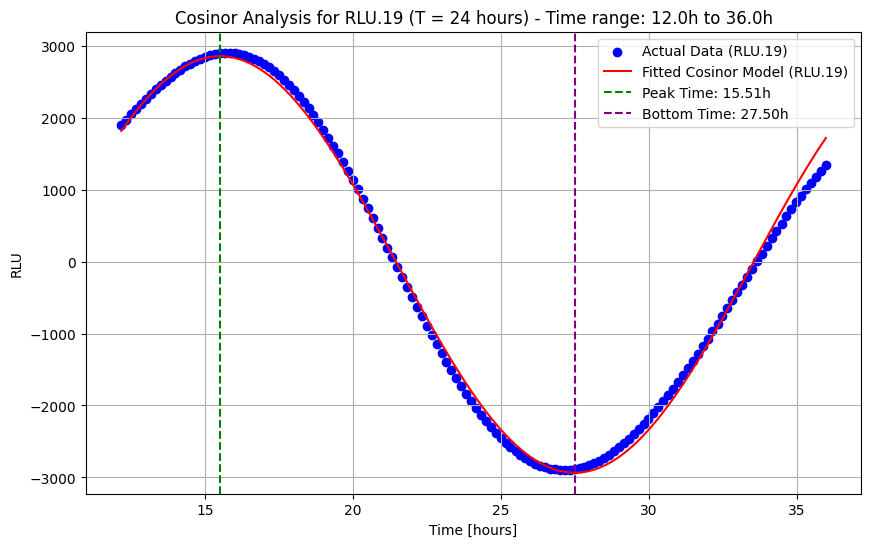

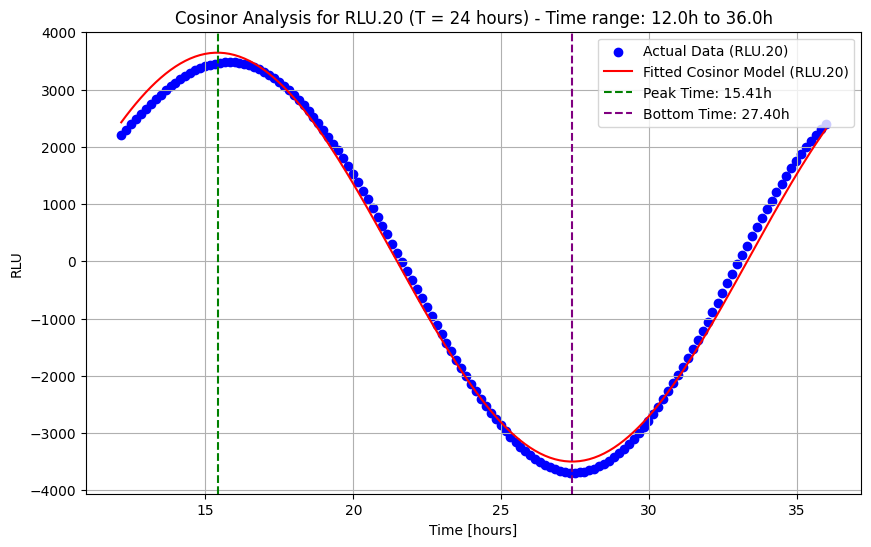

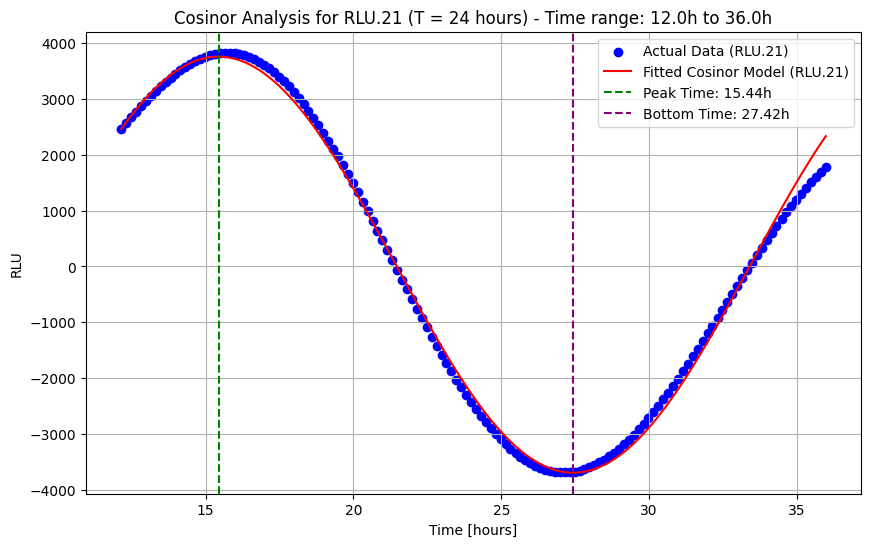

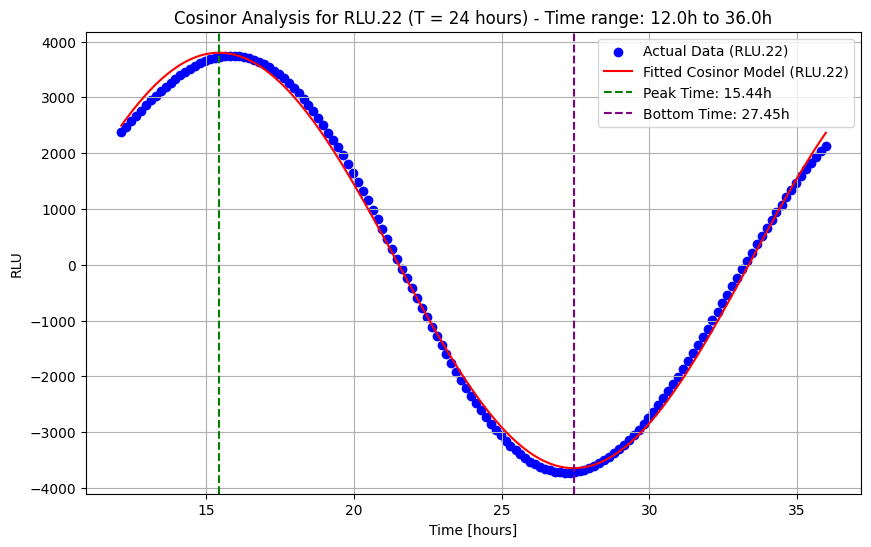

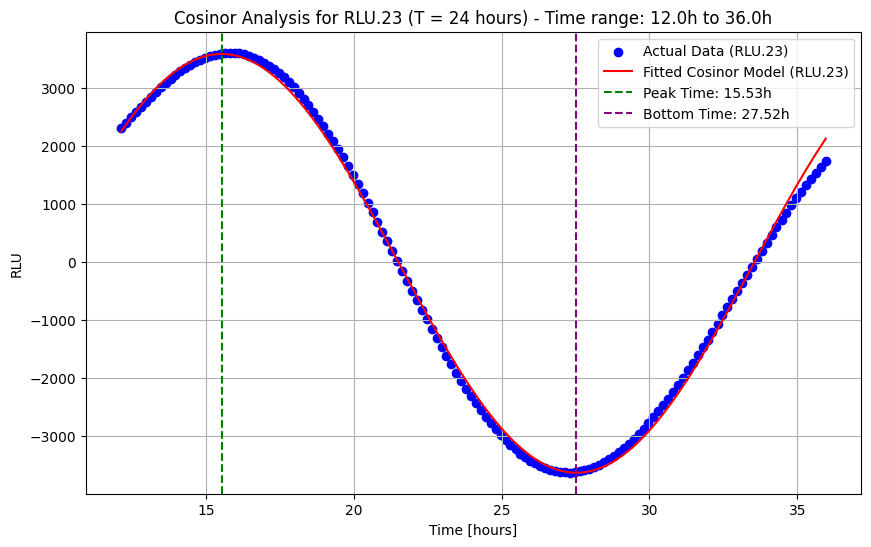

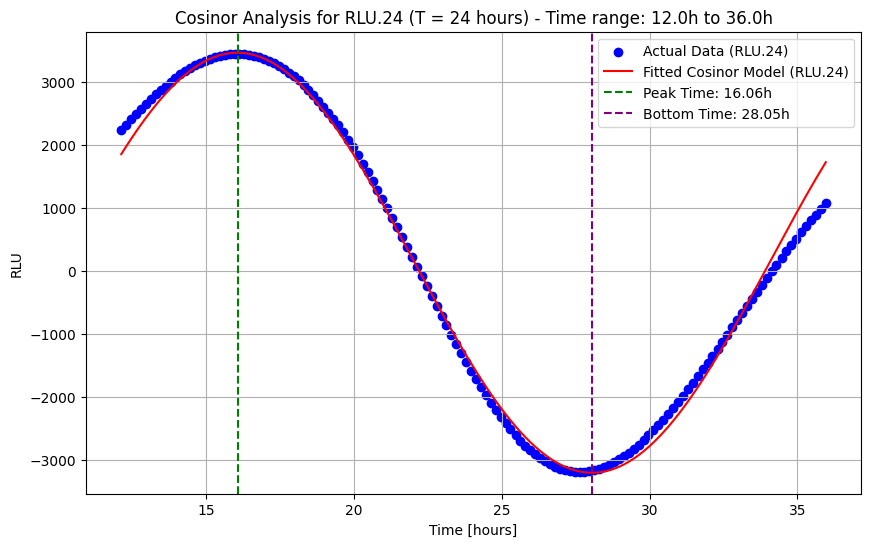

Results with peak and bottom time saved to /content/cosinor_analysis_peak_and_bottom_time.csv
  Measurement        MESOR    Amplitude  Phase (radians)  Peak Time (hours)  \
0         RLU  1241.756944    78.372409         4.801703          29.657658   
1       RLU.1   113.099132  1759.072910         2.397642          14.834835   
2       RLU.2   134.518941  2017.815473         2.339806          15.051051   
3       RLU.3   140.925293  2021.797906         2.337602          15.075075   
4       RLU.4   175.125165  2186.810056         2.199273          15.603604   

   Bottom Time (hours)  
0            17.669670  
1            26.846847  
2            27.063063  
3            27.063063  
4            27.591592  


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# データの読み込み
csv_file_path = '/content/2024-0923-1048_Plate1_F0_N_D.csv'
data = pd.read_csv(csv_file_path, skiprows=11)

# 周期を24時間と仮定
T = 24

# Cosinor.Onlineに基づいた線形モデル
def linear_cosinor_model(t, mesor, Acos_phi, Asin_phi):
    return mesor + Acos_phi * np.cos(2 * np.pi * t / T) + Asin_phi * np.sin(2 * np.pi * t / T)

# 各測定項目の「Time(h)」と「RLU」をペアで処理
measurement_pairs = []
for i in range(1, len(data.columns), 2):  # Time(h) と RLU をペアにする
    time_col = data.columns[i]  # "Time(h)"
    rlu_col = data.columns[i+1]  # "RLU"
    measurement_pairs.append((time_col, rlu_col))

# 特定の時間帯を設定（例：時間の開始と終了）
start_time = 12.0
end_time = 36.0

# コサイナー解析の結果を保存するリスト
results = []

# 各測定項目に対してコサイナー解析を実行
for time_col, rlu_col in measurement_pairs:
    time_data = pd.to_numeric(data[time_col], errors='coerce')
    rlu_data = pd.to_numeric(data[rlu_col], errors='coerce')

    # 特定の時間帯にデータをフィルタリング
    valid_indices = (time_data >= start_time) & (time_data <= end_time) & (rlu_data.notna())
    time_data_filtered = time_data[valid_indices]
    rlu_data_filtered = rlu_data[valid_indices]

    # フィルタされたデータに基づいてコサイン解析を行う
    if len(time_data_filtered) > 0 and len(rlu_data_filtered) > 0:
        # 初期値設定
        initial_guess = [np.mean(rlu_data_filtered), 1, 1]  # MESOR, Acos_phi, Asin_phi

        # 線形モデルのフィッティング
        params, params_covariance = curve_fit(linear_cosinor_model, time_data_filtered, rlu_data_filtered, p0=initial_guess)

        # フィット結果の取得
        fitted_mesor, fitted_Acos_phi, fitted_Asin_phi = params

        # 振幅の計算
        fitted_amplitude = np.sqrt(fitted_Acos_phi**2 + fitted_Asin_phi**2)

        # 位相の計算
        fitted_phase = np.arctan2(-fitted_Asin_phi, fitted_Acos_phi)
        if fitted_phase < 0:
            fitted_phase += 2 * np.pi  # 位相は正の値に変換

        # データ範囲内で頂点位相とボトムを数値的に特定
        time_range = np.linspace(start_time, end_time, 1000)  # 指定時間帯のデータ点を細かく取る
        fitted_values = linear_cosinor_model(time_range, fitted_mesor, fitted_Acos_phi, fitted_Asin_phi)
        max_index = np.argmax(fitted_values)  # 最大値のインデックスを取得（頂点位相）
        min_index = np.argmin(fitted_values)  # 最小値のインデックスを取得（ボトム）

        peak_time = time_range[max_index]  # 頂点位相の時間
        bottom_time = time_range[min_index]  # ボトムの時間

        # 結果を保存
        results.append({
            'Measurement': rlu_col,
            'MESOR': fitted_mesor,
            'Amplitude': fitted_amplitude,
            'Phase (radians)': fitted_phase,
            'Peak Time (hours)': peak_time,
            'Bottom Time (hours)': bottom_time
        })

        # フィッティング結果のプロット
        plt.figure(figsize=(10, 6))
        plt.scatter(time_data_filtered, rlu_data_filtered, label=f'Actual Data ({rlu_col})', color='blue')
        plt.plot(time_data_filtered, linear_cosinor_model(time_data_filtered, fitted_mesor, fitted_Acos_phi, fitted_Asin_phi),
                 label=f'Fitted Cosinor Model ({rlu_col})', color='red')
        plt.axvline(peak_time, color='green', linestyle='--', label=f'Peak Time: {peak_time:.2f}h')
        plt.axvline(bottom_time, color='purple', linestyle='--', label=f'Bottom Time: {bottom_time:.2f}h')
        plt.title(f'Cosinor Analysis for {rlu_col} (T = {T} hours) - Time range: {start_time}h to {end_time}h')
        plt.xlabel('Time [hours]')
        plt.ylabel('RLU')
        plt.legend()
        plt.grid(True)
        plt.show()

# 結果をデータフレームに
results_df = pd.DataFrame(results)

# 振幅を絶対値に変換
results_df['Amplitude'] = results_df['Amplitude'].abs()

# 解析結果をCSVファイルに保存
output_csv_file_path = '/content/cosinor_analysis_peak_and_bottom_time.csv'
results_df.to_csv(output_csv_file_path, index=False)

print(f"Results with peak and bottom time saved to {output_csv_file_path}")

# 結果のプレビュー表示
print(results_df.head())